In [1]:
%load_ext autoreload
%autoreload 2
from boxes import *
from learner import *
import math
import matplotlib.pyplot as plt
import os
import wandb

%matplotlib inline

/home/zonghaiyao/anaconda3/envs/run_boxmodel/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
use_cuda

True

In [3]:
PATH = '../data/ontologies/anatomy/'

# aligment training split
ats = 0.8

# Transitive closure
Transitive_Closure = True

if Transitive_Closure:
    tc = "tc_"
else:
    tc = ""

# Data in unary.tsv are probabilites separated by newlines. The probability on line n is P(n), where n is the id assigned to the nth element.
unary_prob = torch.from_numpy(np.loadtxt(f'{PATH}unary/unary.tsv')).float().to(device)
num_boxes = unary_prob.shape[0]

# We're going to use random negative sampling during training, so no need to include negatives in our training data itself
train = Probs.load_from_julia(PATH, f'tr_pos_{tc}{ats}.tsv', f'tr_neg_{ats}.tsv', ratio_neg = 0).to(device)

# The dev set will have a fixed set of negatives, however.
dev = Probs.load_from_julia(PATH, f'dev_align_pos_{ats}.tsv', f'dev_align_neg_{ats}.tsv', ratio_neg = 1).to(device)

# This set is used just for evaluation purposes after training
tr_align = Probs.load_from_julia(PATH, f'tr_align_pos_{ats}.tsv', f'tr_align_neg_{ats}.tsv', ratio_neg = 1).to(device)


In [4]:
mouse_eval = Probs.load_from_julia(PATH, 'human_dev_pos.tsv', 'human_dev_neg.tsv', ratio_neg = 1).to(device)
human_eval = Probs.load_from_julia(PATH, 'mouse_dev_pos.tsv', 'mouse_dev_neg.tsv', ratio_neg = 1).to(device)

In [5]:
dims = 16
lr = 0.07342406890949607
rns_ratio = 5
box_type = SigmoidBoxes
use_unary = False
unary_weight = 1e-2

In [6]:
box_model = BoxModel(
    BoxParamType=box_type,
    vol_func=soft_volume,
    num_models=1,
    num_boxes=num_boxes,
    dims=dims,
    method="orig").to(device)

#### IF YOU ARE LOADING FROM JULIA WITH ratio_neg=0, train_dl WILL ONLY CONTAIN POSITIVE EXAMPLES
#### THIS MEANS YOUR MODEL SHOULD USE NEGATIVE SAMPLING DURING TRAINING
train_dl = TensorDataLoader(train, batch_size=2**6, shuffle=True)

mouse_dl = TensorDataLoader(mouse_eval, batch_size=2**6)
human_dl = TensorDataLoader(human_eval, batch_size=2**6)

eval_dl = [mouse_dl, human_dl]

opt = torch.optim.Adam(box_model.parameters(), lr=lr)

In [7]:
def mean_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

def human_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

def mouse_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

def align_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

# See boxes/loss_functions.py file for more options. Note that you may have to changed them to fit your use case.
# Also note that "kl_div_sym" is just binary cross-entropy.

def mean_reciprocal_rank(model, data_in, data_out) -> Tensor:
    ratio = 5
    
    batch_in = data_in.to("cpu") # Should be a tensor of indices, shape (batch_size, k) 
    batch_size, k = batch_in.shape
    num_neg_samples = batch_in.shape[0] * ratio
    negative_samples = batch_in.repeat(ratio, 1) # shape (batch_size * ratio, k)
    negative_probs = torch.zeros(num_neg_samples).to(data_out.device)
    negative_samples.scatter_(1, torch.randint(k,(num_neg_samples,1)), torch.randint(num_boxes, (num_neg_samples,1)))
    negative_samples = negative_samples.to(batch_in.device)
    positive_data = batch_in
    negative_data = negative_samples 
    
    
    positive_score = torch.reshape(model(positive_data)["P(A|B)"], (batch_size, 1))
    negative_score = torch.reshape(model(negative_data)["P(A|B)"], (batch_size, ratio))
    
    
    scores = torch.cat((positive_score, negative_score), dim=-1)
    
    _, loss_idx = scores.sort(dim=1, descending=True)
    _, idx_rank = loss_idx.sort(dim=1)
    print(batch_size, idx_rank[:, 0])
    MRR = idx_rank[:, 0].sum()/float(batch_size)
    print(MRR)
    
    return MRR

In [8]:
@dataclass
class Learner:
    train_dl: DataLoader
    model: Module
    loss_fn: Callable
    opt: optim.Optimizer
    callbacks: CallbackCollection = field(default_factory=CallbackCollection)
    recorder: Recorder = field(default_factory=Recorder)
    categories: bool = False
    use_wandb: bool = False
    reraise_keyboard_interrupt: bool = False
    reraise_stop_training_exceptions: bool = False

    def __post_init__(self):
        self.progress = Progress(0,0,len(self.train_dl))
        self.callbacks.learner_post_init(self)

    #the split parameter will be used to find human/mouse/align data, so you need change it when using diff dataset(index)
    def split_data(self, batch_in, batch_out, split):
        category = torch.zeros(size=(batch_in.shape[0],), dtype=int)

        batch_class = batch_in > split

        for i, (a,b) in enumerate(batch_class):
            if not a and not b:
                category[i] = 0
            elif a and b:
                category[i] = 1
            else:
                category[i] = 2

        self.mouse_in = batch_in[category == 0]
        self.human_in = batch_in[category == 1]
        self.align_in = batch_in[category == 2]

        self.mouse_out = batch_out[category == 0]
        self.human_out = batch_out[category == 1]
        self.align_out = batch_out[category == 2]

        # INPUT TO THE MODEL:
        data_in = (self.mouse_in, self.human_in, self.align_in)
        # TARGET/LABEL:
        data_out = (self.mouse_out, self.human_out, self.align_out)

        return data_in, data_out

    def TensorNaN(self, size:Union[None,List[int], Tuple[int]]=None, device=None, requires_grad:bool=True):
        if size is None:    
            return torch.tensor(float('nan'), device=device, requires_grad=requires_grad)
        else:
            return float('nan') * torch.zeros(size=size, device=device, requires_grad=requires_grad)


    def train(self, epochs, progress_bar = True):
        try:
            self.callbacks.train_begin(self)
            for epoch in trange(epochs, desc="Overall Training:", disable=not progress_bar):
                self.callbacks.epoch_begin(self)
                for iteration, batch in enumerate(tqdm(self.train_dl, desc="Current Batch:", leave=False, disable=not progress_bar)):
                    if len(batch) == 2: # KLUDGE
                        self.batch_in, self.batch_out = batch
                    else:
                        self.batch_in = batch[0]
                        self.batch_out = None
                    self.progress.increment()
                    self.callbacks.batch_begin(self)
                    self.opt.zero_grad()
                    
                    if self.categories:
                        self.data_in, self.data_out = self.split_data(self.batch_in, self.batch_out, split=2737)
                        #2737 is max mouse index
                        self.model_pred = [self.model(item) if len(item)>0 else {'P(A|B)':self.TensorNaN(device=self.batch_in.device)} for item in self.data_in]
                        self.loss = self.loss_fn(self.model_pred, self.data_out, self, self.recorder, categories=True, use_wandb=self.use_wandb)                        
                    else:
                        self.model_out = self.model(self.batch_in)
                        if self.batch_out is None:
                            self.loss = self.loss_fn(self.model_out, self, self.recorder, categories=True, use_wandb=self.use_wandb)
                        else:
                            self.loss = self.loss_fn(self.model_out, self.batch_out, self, self.recorder, categories=True, use_wandb=self.use_wandb)
                        
                    # Log metrics inside your training loop
                    if self.use_wandb:
                        metrics = {'epoch': epoch, 'loss': self.loss}
                        wandb.log(metrics)

                    # print(self.recorder.dataframe)
                    self.loss.backward()
                    self.callbacks.backward_end(self)
                    self.opt.step()
                    self.callbacks.batch_end(self)
                # print(self.recorder.dataframe)
                
                # run evaluating at the end of every epoch
                self.evaluation(np.arange(0.1, 1, 0.1))
                
                
                self.callbacks.epoch_end(self)
        except StopTrainingException as e:
            print(e)
            if self.reraise_stop_training_exceptions:
                raise e
        except KeyboardInterrupt:
            print(f"Stopped training at {self.progress.partial_epoch_progress()} epochs due to keyboard interrupt.")
            if self.reraise_keyboard_interrupt:
                raise KeyboardInterrupt
        finally:
            self.callbacks.train_end(self)


    def evaluation(self, trials, progress_bar=True):
        with torch.no_grad():
            # self.callbacks.eval_begin(self)
            for t in trials:
                self.callbacks.eval_align(self, t)
            self.callbacks.metric_plots(self)
            self.callbacks.bias_metric(self)
            self.callbacks.eval_end(self)

In [9]:
# For this dataset we had unary probabilities as well as conditional probabilities. Our loss function will be a sum of these, which is provided by the following loss function wrapper:

# if use_unary:
#     loss_func = LossPieces(mean_cond_kl_loss, (unary_weight, mean_unary_kl_loss(unary_prob)))
# else:
#     loss_func = LossPieces(mean_cond_kl_loss)

loss_func = LossPieces( (0.01567001290789961,mouse_cond_kl_loss), (0.01567001290789961,human_cond_kl_loss), (0.059308290879279614,align_cond_kl_loss))

metrics = [metric_hard_accuracy, metric_hard_f1]
align_metrics = [metric_hard_accuracy_align, metric_hard_f1_align, metric_hard_accuracy_align_mean, metric_hard_f1_align_mean]

rec_col = RecorderCollection()

threshold = np.arange(0.1, 1, 0.1)

callbacks = CallbackCollection(
    LossCallback(rec_col.train, train),
    LossCallback(rec_col.dev, dev),
    *(MetricCallback(rec_col.dev, dev, "dev", m) for m in metrics),
    *(MetricCallback(rec_col.train, train, "train", m) for m in metrics),
    *(MetricCallback(rec_col.onto, human_eval, "human", m) for m in metrics),
    *(MetricCallback(rec_col.onto, mouse_eval, "mouse", m) for m in metrics),
    *(EvalAlignment(rec_col.train_align, tr_align, "train_align", m) for m in align_metrics),
    *(EvalAlignment(rec_col.dev_align, dev, "dev_align", m) for m in align_metrics),
    JustGiveMeTheData(rec_col.probs, dev, get_probabilities),
    BiasMetric(rec_col.bias, dev, pct_of_align_cond_on_human_as_min),
    PlotMetrics(rec_col.dev_roc_plot, dev, roc_plot),
    PlotMetrics(rec_col.dev_pr_plot, dev, pr_plot),
    PlotMetrics(rec_col.tr_roc_plot, tr_align, roc_plot),
    PlotMetrics(rec_col.tr_pr_plot, tr_align, pr_plot),
    MetricCallback(rec_col.train, train, 'train', metric_pearson_r),
    MetricCallback(rec_col.train, train, 'train', metric_spearman_r),
    MetricCallback(rec_col.dev, dev, 'dev', metric_pearson_r),
    MetricCallback(rec_col.dev, dev, 'dev', metric_spearman_r),
#     MetricCallback(rec_col.train, train, 'train', mean_reciprocal_rank),
#     MetricCallback(rec_col.dev, dev, 'dev', mean_reciprocal_rank),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mean_cond_kl_loss", 0.25, 10),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mean_cond_kl_loss", 0.5),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mouse_cond_kl_loss", 0.25, 10),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mouse_cond_kl_loss", 0.5),
#     GradientClipping(-1000,1000),
    RandomNegativeSampling(num_boxes, rns_ratio),
    StopIfNaN(),
)

# l = Learner(train_dl, box_model, loss_func, opt, callbacks, recorder = rec_col.learn)
l = Learner(train_dl, box_model, loss_func, opt, callbacks, recorder = rec_col.learn, categories=True)

In [10]:
nEpochs = 50

In [11]:
l.train(nEpochs)

evaluation_dev_metric_hard_accuracy tensor(0.5000, device='cuda:0')
evaluation_dev_metric_hard_f1 tensor(nan, device='cuda:0')
evaluation_train_metric_hard_accuracy tensor(0., device='cuda:0')
evaluation_train_metric_hard_f1 tensor(nan, device='cuda:0')
evaluation_human_metric_hard_accuracy tensor(0.5000, device='cuda:0')
evaluation_human_metric_hard_f1 tensor(nan, device='cuda:0')
evaluation_mouse_metric_hard_accuracy_1 tensor(0.5000, device='cuda:0')
evaluation_mouse_metric_hard_f1_1 tensor(nan, device='cuda:0')
evaluation_train_metric_pearson_r tensor(0., device='cuda:0')
evaluation_train_metric_spearman_r nan
evaluation_dev_metric_pearson_r tensor(-0.0333, device='cuda:0')
evaluation_dev_metric_spearman_r -0.011984507510418943


/home/zonghaiyao/anaconda3/envs/run_boxmodel/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/zonghaiyao/anaconda3/envs/run_boxmodel/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.5589, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.2671, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5404, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.3391, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5099, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.1441, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4884, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.2172, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5305, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.1352, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5346, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.5697, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.3483, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5519, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.4083, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5198, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.1983, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4917, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.2701, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5544, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.2262, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5470, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.5824, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.3916, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5639, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.4478, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5066, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.1984, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4983, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.2995, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5589, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.2507, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5589, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.5779, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.3934, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5622, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.4576, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5066, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.2069, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4967, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.3177, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5622, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.2676, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5577, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.5890, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.4300, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5655, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.4782, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5182, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.2316, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5017, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.3289, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5672, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.2788, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5622, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.5969, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.4512, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5684, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.4880, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5182, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.2396, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5116, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.3451, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5754, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3050, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5680, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.5952, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.4477, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5697, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.4862, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5330, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.2799, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5000, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.3484, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5824, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3278, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5754, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6002, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.4664, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5705, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5000, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5248, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.2577, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5017, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.3519, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5837, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3347, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5771, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6088, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.4800, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5796, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5170, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5215, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.2487, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5149, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.3771, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5829, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3298, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5750, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6063, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.4846, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5758, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5144, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5198, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.2850, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5149, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.3875, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5866, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3474, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5779, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.5977, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.4781, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5721, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5163, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5314, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.2864, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5347, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4100, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5804, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3381, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5738, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6080, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.4933, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5866, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5324, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5297, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.2998, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5215, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4008, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5870, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3494, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5750, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6142, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5074, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5763, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5276, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5198, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.2850, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5000, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.3778, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5845, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3463, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5812, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6117, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5047, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5767, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5308, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5297, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3165, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5050, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.3902, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5894, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3532, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5779, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6162, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5138, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5820, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5387, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5330, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3246, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5066, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4056, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5956, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3787, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5899, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6158, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5100, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5820, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5428, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5429, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3293, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5182, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4160, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5874, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3554, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5845, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6212, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5231, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5890, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5515, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5314, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3238, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5198, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4073, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5919, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3646, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5833, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6200, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5286, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5857, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5531, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5347, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3318, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5297, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4242, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5952, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3761, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5927, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6088, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5136, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5857, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5507, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5330, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3372, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5132, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4112, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5899, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3626, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5849, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6117, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5149, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5882, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5538, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5347, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3349, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5132, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4204, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5894, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3728, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5841, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6195, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5254, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5886, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5541, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5380, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3333, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4967, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.3912, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5948, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3751, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5886, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6092, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5133, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5833, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5521, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5149, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3194, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5050, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4186, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5993, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3955, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5870, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6167, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5303, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5862, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5593, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5314, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3456, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5099, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4211, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5911, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3792, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5853, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6175, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5383, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5919, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5673, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5215, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3349, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5198, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4371, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5977, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3885, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5890, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6195, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5373, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5894, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5620, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5347, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3649, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5066, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4172, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5981, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3902, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5894, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6183, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5370, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5899, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5657, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5314, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3545, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5083, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4247, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6010, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.4017, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5944, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6117, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5318, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5796, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5561, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5297, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3508, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5149, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4368, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6014, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.4049, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5969, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6109, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5350, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5800, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5583, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5330, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3554, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5050, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4118, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6014, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3990, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5853, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6113, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5283, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5866, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5622, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5330, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3583, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5165, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4376, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5890, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3780, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5870, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6138, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5308, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5862, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5639, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5264, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3247, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4950, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4070, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5969, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3895, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5882, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6195, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5401, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5903, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5678, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5281, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3410, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5017, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4147, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6031, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3993, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5952, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6088, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5248, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5870, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5621, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5281, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3470, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4934, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4152, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6035, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.4062, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5894, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6200, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5408, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5907, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5673, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5330, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3494, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5033, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4155, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6010, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3965, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5936, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6162, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5357, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5927, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5697, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5231, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3387, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5033, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4245, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5969, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3910, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5874, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6175, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5433, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5866, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5712, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5149, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3378, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5083, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4313, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5952, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3862, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5853, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6171, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5426, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5870, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5714, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5380, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3636, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5198, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4415, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5936, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3868, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5882, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6175, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5415, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5808, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5626, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5231, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3356, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5083, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4225, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5969, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3910, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5833, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6162, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5412, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5820, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5652, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5281, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3500, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5149, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4258, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5965, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3990, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5837, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6183, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5425, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5890, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5656, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5231, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3447, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5149, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4302, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6051, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.4079, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5882, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6183, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5461, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5874, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5706, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5264, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3341, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5116, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4286, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5965, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3931, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5882, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6191, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5430, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5952, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5778, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5116, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3303, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4950, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4160, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6010, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3950, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5878, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6216, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5482, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5932, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5751, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5347, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3620, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5132, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4381, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6031, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3993, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5903, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6241, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5507, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5919, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5747, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5314, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3604, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5182, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4470, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6031, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.4052, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5919, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6261, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5573, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5907, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5736, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5248, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3333, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5099, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4255, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6014, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.4049, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5981, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6257, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5531, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5919, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5744, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5297, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3478, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5132, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4316, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5998, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.4054, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5907, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6171, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5497, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5857, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5689, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5198, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3371, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5231, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4557, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6059, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.4142, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.6043, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6171, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5466, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5849, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5684, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5281, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3500, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5116, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4436, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6055, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.4111, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5952, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6208, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5499, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5894, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5707, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5264, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3692, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5182, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4491, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5998, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.4047, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5956, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6232, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5533, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5952, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5760, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5231, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3506, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4967, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4256, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6043, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.4118, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5973, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6154, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.5464, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5812, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.5651, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5330, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3612, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5165, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4482, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6022, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.4083, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.5940, device='cuda:0')
a

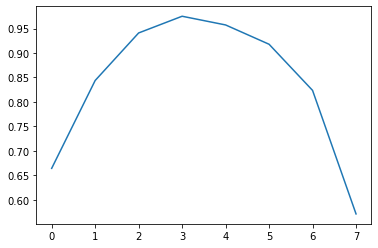

In [29]:
#align_evaluation_train_align_0.9_metric_hard_f1_align
plt.plot([0.7485, 0.8649, 0.9442, 0.9716, 0.9750, 0.9558, 0.9106, 0.7858, 0.2484])



In [17]:
l.train(nEpochs)

evaluation_dev_metric_hard_accuracy tensor(0.4901, device='cuda:0')
evaluation_dev_metric_hard_f1 tensor(0.1197, device='cuda:0')
evaluation_train_metric_hard_accuracy tensor(0.9339, device='cuda:0')
evaluation_train_metric_hard_f1 tensor(0.9658, device='cuda:0')
evaluation_human_metric_hard_accuracy tensor(0.9399, device='cuda:0')
evaluation_human_metric_hard_f1 tensor(0.9400, device='cuda:0')
evaluation_mouse_metric_hard_accuracy_1 tensor(0.9294, device='cuda:0')
evaluation_mouse_metric_hard_f1_1 tensor(0.9286, device='cuda:0')
evaluation_train_metric_pearson_r tensor(0., device='cuda:0')
evaluation_train_metric_spearman_r nan
evaluation_dev_metric_pearson_r tensor(-0.1513, device='cuda:0')
evaluation_dev_metric_spearman_r -0.19704398062584913
11293 tensor([0, 0, 0,  ..., 1, 0, 0], device='cuda:0')
tensor(0.2208, device='cuda:0')
evaluation_train_mean_reciprocal_rank tensor(0.2208, device='cuda:0')
1212 tensor([4, 1, 2,  ..., 1, 2, 1], device='cuda:0')
tensor(2.1205, device='cuda:0')

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6443, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7376, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5346, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6824, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3977, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4560, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3993, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5506, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8487, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8685, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7061, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6472, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7392, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5354, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6828, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4142, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4802, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4026, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5509, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8483, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8682, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7057, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6509, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7412, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5359, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6830, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4125, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4702, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4010, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5479, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8545, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8730, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7036, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6480, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7396, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5363, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6832, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3993, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4583, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4026, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5486, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8545, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8730, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7028, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6496, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7405, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5375, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6838, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4076, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4666, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4059, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5545, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8537, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8723, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7032, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6496, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7405, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5392, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6845, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4175, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4739, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4142, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5590, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8491, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8689, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7090, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6480, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7396, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5396, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6847, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4043, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4636, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4059, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5511, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8553, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8736, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7073, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6513, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7414, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5396, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6847, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4059, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4611, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4043, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5493, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8516, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8708, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7086, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6546, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7433, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5412, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6855, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4026, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4565, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4010, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5468, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8458, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8664, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7082, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6546, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7433, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5416, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6857, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4010, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4558, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4043, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5471, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8491, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8689, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7061, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6570, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7446, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5425, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6861, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4059, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4627, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4010, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5422, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8504, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8698, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7065, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6562, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7442, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5437, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6867, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3960, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4537, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4026, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5452, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8508, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8702, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7090, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6608, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7467, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5453, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6874, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3927, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4507, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4026, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5452, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8450, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8658, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7086, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6624, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7476, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5429, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6863, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3911, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4549, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3960, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5367, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8479, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8680, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7065, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6649, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7490, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5462, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6878, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3960, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4586, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3944, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5360, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8487, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8686, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7065, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6645, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7488, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5491, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6892, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3911, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4517, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3944, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5372, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8454, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8661, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7053, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6653, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7492, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5491, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6892, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3927, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4540, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3993, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5416, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8442, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8652, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7040, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6649, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7490, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5511, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6902, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3927, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4588, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3861, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5327, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8442, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8652, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7049, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6649, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7490, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5507, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6900, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3977, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4560, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3894, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5352, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8479, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8680, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7024, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6641, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7485, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5519, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6906, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4010, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4622, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3911, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5335, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8438, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8649, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7032, device='cuda:0')
a

In [11]:
l.evaluation(threshold)

tensor([[  93, 3629],
        [3629,   93],
        [1379, 4595],
        ...,
        [ 438, 4767],
        [2505, 2873],
        [2873, 2505]], device='cuda:0')
tensor([[4744,  791],
        [ 791, 4744],
        [2450, 5960],
        ...,
        [2860,  464],
        [2676, 5717],
        [5717, 2676]], device='cuda:0')
tensor([[  93, 3629],
        [3629,   93],
        [1379, 4595],
        ...,
        [ 438, 4767],
        [2505, 2873],
        [2873, 2505]], device='cuda:0')
tensor([[4744,  791],
        [ 791, 4744],
        [2450, 5960],
        ...,
        [2860,  464],
        [2676, 5717],
        [5717, 2676]], device='cuda:0')
tensor([[  93, 3629],
        [3629,   93],
        [1379, 4595],
        ...,
        [ 438, 4767],
        [2505, 2873],
        [2873, 2505]], device='cuda:0')
tensor([[4744,  791],
        [ 791, 4744],
        [2450, 5960],
        ...,
        [2860,  464],
        [2676, 5717],
        [5717, 2676]], device='cuda:0')
tensor([[  93, 3629],


In [12]:
rec_col.train

0.05*align_cond_kl_loss  human_cond_kl_loss      loss  \
0.0                  0.101246            2.052412  4.139367   
1.0                  0.041757            0.725121  1.549436   
2.0                  0.040762            0.652182  1.403351   
3.0                  0.040892            0.609991  1.309038   
4.0                  0.040200            0.568517  1.204336   
5.0                  0.040206            0.538850  1.140987   
6.0                  0.040884            0.511565  1.101887   
7.0                  0.040745            0.506880  1.065870   
8.0                  0.040098            0.481300  1.012023   
9.0                  0.039787            0.468834  0.988309   
10.0                 0.039426            0.450497  0.954795   
11.0                 0.039591            0.442861  0.935258   
12.0                 0.039233            0.433378  0.914445   
13.0                 0.039408            0.424114  0.905836   
14.0                 0.038803            0.428932  0.884101   
15.0                 0.039150            0.422813  0.880923   
16.0                 0.038283            0.404938  0.855208   
17.0                 0.038290            0.409225  0.851522   
18.0                 0.038929            0.408634  0.857293   
19.0                 0.038874            0.404795  0.847456   
20.0                 0.038212            0.402865  0.831036   

      metric_hard_accuracy  metric_hard_f1  metric_pearson_r  \
0.0               0.001967        0.003926               0.0   
1.0               0.423836        0.595344               0.0   
2.0               0.464330        0.634188               0.0   
3.0               0.479324        0.648032               0.0   
4.0               0.507563        0.673355               0.0   
5.0               0.514464        0.679401               0.0   
6.0               0.510992        0.676367               0.0   
7.0               0.507684        0.673462               0.0   
8.0               0.526330        0.689668               0.0   
9.0               0.534688        0.696804               0.0   
10.0              0.543419        0.704176               0.0   
11.0              0.537539        0.699220               0.0   
12.0              0.547690        0.707752               0.0   
13.0              0.554173        0.713142               0.0   
14.0              0.562217        0.719768               0.0   
15.0              0.554081        0.713066               0.0   
16.0              0.575657        0.730688               0.0   
17.0              0.569737        0.725901               0.0   
18.0              0.562825        0.720266               0.0   
19.0              0.562357        0.719883               0.0   
20.0              0.571753        0.727535               0.0   

      metric_spearman_r  mouse_cond_kl_loss  
0.0                 NaN            1.985710  
1.0                 NaN            0.782558  
2.0                 NaN            0.710407  
3.0                 NaN            0.658155  
4.0                 NaN            0.595619  
5.0                 NaN            0.561930  
6.0                 NaN            0.549438  
7.0                 NaN            0.518245  
8.0                 NaN            0.490625  
9.0                 NaN            0.479688  
10.0                NaN            0.464872  
11.0                NaN            0.452806  
12.0                NaN            0.441834  
13.0                NaN            0.442314  
14.0                NaN            0.416366  
15.0                NaN            0.418959  
16.0                NaN            0.411987  
17.0                NaN            0.404006  
18.0                NaN            0.409730  
19.0                NaN            0.403787  
20.0                NaN            0.389959

In [13]:
rec_col.dev

0.05*align_cond_kl_loss  human_cond_kl_loss      loss  \
0.0                  0.054029                 NaN  0.054029   
1.0                  0.058552                 NaN  0.058552   
2.0                  0.062936                 NaN  0.062936   
3.0                  0.066023                 NaN  0.066023   
4.0                  0.068025                 NaN  0.068025   
5.0                  0.069085                 NaN  0.069085   
6.0                  0.069291                 NaN  0.069291   
7.0                  0.069460                 NaN  0.069460   
8.0                  0.069263                 NaN  0.069263   
9.0                  0.068784                 NaN  0.068784   
10.0                 0.068606                 NaN  0.068606   
11.0                 0.068811                 NaN  0.068811   
12.0                 0.068523                 NaN  0.068523   
13.0                 0.068324                 NaN  0.068324   
14.0                 0.068648                 NaN  0.068648   
15.0                 0.068389                 NaN  0.068389   
16.0                 0.068065                 NaN  0.068065   
17.0                 0.067786                 NaN  0.067786   
18.0                 0.068004                 NaN  0.068004   
19.0                 0.067911                 NaN  0.067911   
20.0                 0.067734                 NaN  0.067734   

      metric_hard_accuracy  metric_hard_f1  metric_pearson_r  \
0.0               0.499175        0.006547          0.044865   
1.0               0.503300        0.047468          0.020151   
2.0               0.502475        0.047393          0.010249   
3.0               0.498350        0.037975         -0.005482   
4.0               0.502475        0.044374         -0.002229   
5.0               0.494224        0.019200         -0.003918   
6.0               0.493399        0.022293         -0.009984   
7.0               0.495050        0.028571         -0.004255   
8.0               0.494224        0.019200         -0.003262   
9.0               0.495875        0.025518          0.002939   
10.0              0.496700        0.031746          0.007265   
11.0              0.495050        0.037736         -0.006662   
12.0              0.498350        0.052960         -0.010059   
13.0              0.497525        0.040945         -0.011486   
14.0              0.492574        0.046512         -0.025717   
15.0              0.494224        0.058372         -0.018385   
16.0              0.496700        0.058642         -0.019016   
17.0              0.494224        0.061256         -0.014446   
18.0              0.494224        0.061256         -0.030785   
19.0              0.494224        0.058372         -0.035107   
20.0              0.491749        0.055215         -0.030140   

      metric_spearman_r  mouse_cond_kl_loss  
0.0            0.038203                 NaN  
1.0            0.026879                 NaN  
2.0            0.020059                 NaN  
3.0            0.021167                 NaN  
4.0            0.022615                 NaN  
5.0            0.024691                 NaN  
6.0            0.025327                 NaN  
7.0            0.017286                 NaN  
8.0            0.016409                 NaN  
9.0            0.018088                 NaN  
10.0           0.020573                 NaN  
11.0           0.012027                 NaN  
12.0           0.010013                 NaN  
13.0           0.006825                 NaN  
14.0          -0.001311                 NaN  
15.0           0.003707                 NaN  
16.0           0.000000                 NaN  
17.0           0.001618                 NaN  
18.0          -0.006778                 NaN  
19.0          -0.009103                 NaN  
20.0          -0.008259                 NaN

In [14]:
rec_col.train_align

metric_hard_accuracy_align  metric_hard_accuracy_align_mean  \
0.1                    0.537923                         0.510305   
0.2                    0.518137                         0.517725   
0.3                    0.506595                         0.519373   
0.4                    0.501237                         0.513603   
0.5                    0.500824                         0.504122   
0.6                    0.499588                         0.500412   
0.7                    0.499588                         0.500412   
0.8                    0.500000                         0.500000   
0.9                    0.500000                         0.500000   

     metric_hard_f1_align  metric_hard_f1_align_mean  
0.1              0.458716                   0.504174  
0.2              0.239427                   0.344905  
0.3              0.107383                   0.230871  
0.4              0.044234                   0.133627  
0.5              0.017843                   0.052009  
0.6              0.004918                   0.014634  
0.7                   NaN                   0.003289  
0.8                   NaN                        NaN  
0.9                   NaN                        NaN

In [15]:
rec_col.dev_align

metric_hard_accuracy_align  metric_hard_accuracy_align_mean  \
0.1                     0.50165                         0.498350   
0.2                     0.50000                         0.491749   
0.3                     0.49670                         0.486799   
0.4                     0.49835                         0.488449   
0.5                     0.49670                         0.495050   
0.6                     0.49835                         0.496700   
0.7                     0.50000                         0.500000   
0.8                     0.50000                         0.500000   
0.9                     0.50000                         0.500000   

     metric_hard_f1_align  metric_hard_f1_align_mean  
0.1              0.405512                   0.498350  
0.2              0.212987                   0.318584  
0.3              0.072948                   0.166220  
0.4              0.037975                   0.071856  
0.5              0.006515                   0.037736  
0.6                   NaN                        NaN  
0.7                   NaN                        NaN  
0.8                   NaN                        NaN  
0.9                   NaN                        NaN

In [16]:
# $$$$_1 refers to mouse, the metrics without a subscript _1, refer to the human ontology

rec_col.onto

metric_hard_accuracy  metric_hard_accuracy_1  metric_hard_f1  \
0               0.500000                0.500369        0.004049   
1               0.610918                0.627973        0.390355   
2               0.656649                0.669924        0.497770   
3               0.693235                0.712429        0.571139   
4               0.743031                0.748847        0.660399   
5               0.789634                0.775032        0.738306   
6               0.811411                0.800572        0.771101   
7               0.834930                0.819749        0.805208   
8               0.852497                0.834317        0.829244   
9               0.865563                0.850544        0.846841   
10              0.875145                0.860870        0.859016   
11              0.884292                0.870090        0.870847   
12              0.890244                0.875991        0.878300   
13              0.896922                0.882076        0.886545   
14              0.903600                0.888254        0.894670   
15              0.909262                0.889729        0.901248   
16              0.912166                0.895722        0.904949   
17              0.918118                0.896736        0.911903   
18              0.918264                0.899963        0.912155   
19              0.921458                0.902914        0.915876   
20              0.923780                0.904481        0.918541   

    metric_hard_f1_1  
0           0.004775  
1           0.436531  
2           0.530799  
3           0.612402  
4           0.675946  
5           0.718049  
6           0.757647  
7           0.785612  
8           0.805667  
9           0.827682  
10          0.841241  
11          0.853428  
12          0.861097  
13          0.868780  
14          0.876099  
15          0.877984  
16          0.885329  
17          0.886456  
18          0.890526  
19          0.894118  
20          0.896130

In [17]:
rec_col.bias

pct_of_align_cond_on_human_as_min
0                           0.513201

In [18]:
rec_col.probs

Alignment 1 Probablity  Alignment 2 Probablity  Minimum Probablity
0                  0.207232                0.173863            0.173863
1                  0.035018                0.040546            0.035018
2                  0.013036                0.011273            0.011273
3                  0.192903                0.723837            0.192903
4                  0.111053                0.090839            0.090839
..                      ...                     ...                 ...
601                0.474985                0.020003            0.020003
602                0.192557                0.137757            0.137757
603                0.100501                0.083605            0.083605
604                0.016698                0.371385            0.016698
605                0.021196                0.021151            0.021151

[606 rows x 3 columns]

## Make plots

In [19]:
df_train = rec_col.train_align.dataframe

fig1 = plt.figure(num=1, figsize=(10,8), dpi=80, facecolor='white')
plt.plot(df_train, linewidth=3)
plt.ylim((0,1))
plt.xlabel("Alignment Factor")
plt.ylabel("Score")
plt.legend(df_train, loc=0)

# plt.show()

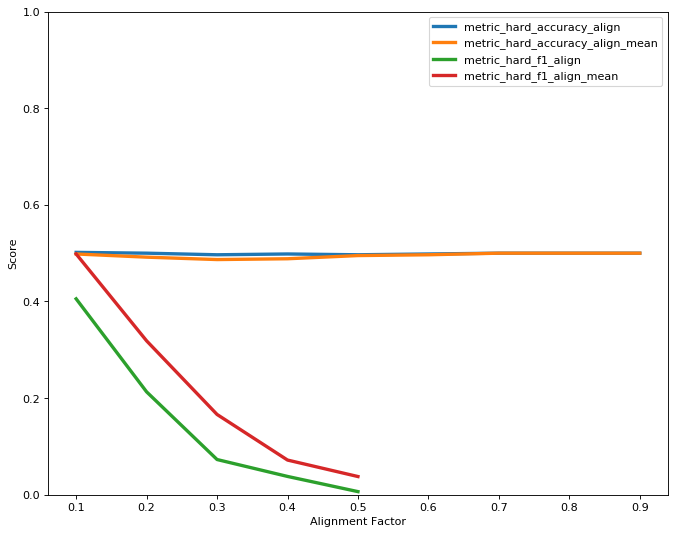

In [20]:
df_dev = rec_col.dev_align.dataframe

fig2 = plt.figure(num=2, figsize=(10,8), dpi=80, facecolor='white')
plt.plot(df_dev, linewidth=3)
plt.ylim((0,1))
plt.xlabel("Alignment Factor")
plt.ylabel("Score")
plt.legend(df_train, loc=0)

# plt.show()

In [21]:
fig3 = plt.figure(num=3, figsize=(10,8), dpi=80, facecolor='white')
plt.plot(rec_col.dev_roc_plot.dataframe['fpr'], rec_col.dev_roc_plot.dataframe['tpr'], linewidth=3)
plt.plot(rec_col.tr_roc_plot.dataframe['fpr'], rec_col.tr_roc_plot.dataframe['tpr'], color='g', linewidth=3)
plt.plot([0, 1], [0, 1], linestyle='--', color='xkcd:orange', linewidth=3)
plt.ylim((0,1.05))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(("Box Model - Dev Alignments", "Box Model - Train Alignments", "No Skill"), loc=0)

# plt.show()

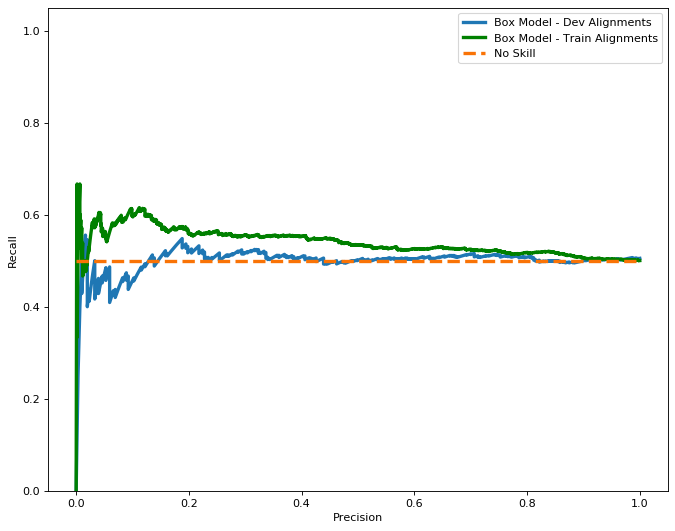

In [22]:
no_skill_pr = dev.probs[dev.probs==1].float().sum()  / dev.probs.shape[0]

fig4 = plt.figure(num=4, figsize=(10,8), dpi=80, facecolor='white')
plt.plot(rec_col.dev_pr_plot.dataframe['recall'], rec_col.dev_pr_plot.dataframe['precision'], linewidth=3)
plt.plot(rec_col.tr_pr_plot.dataframe['recall'], rec_col.tr_pr_plot.dataframe['precision'], color='g', linewidth=3)
plt.plot([0, 1], [no_skill_pr, no_skill_pr], linestyle='--', color='xkcd:orange', linewidth=3)
plt.ylim((0,1.05))
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(("Box Model - Dev Alignments", "Box Model - Train Alignments", "No Skill"), loc=0)

# plt.show()

(606,)


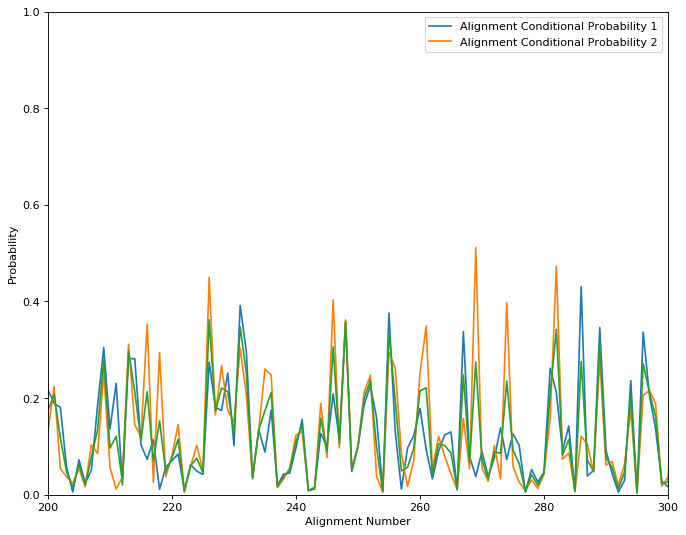

In [23]:
average_min_probability = np.mean(rec_col.probs.dataframe['Minimum Probablity'])
align_pair_probs = np.stack((rec_col.probs.dataframe['Alignment 1 Probablity'], 
                             rec_col.probs.dataframe['Alignment 2 Probablity']), axis=1)

average_align_pair_probs = np.mean(align_pair_probs, axis=1)
print(average_align_pair_probs.shape)

fig = plt.figure(figsize=(10,8), dpi=80, facecolor='white')
plt.plot(range(0, 606), rec_col.probs.dataframe['Alignment 1 Probablity'])
plt.plot(range(0, 606), rec_col.probs.dataframe['Alignment 2 Probablity'])
plt.plot(range(0, 606), average_align_pair_probs)
# plt.plot(range(0, 606), rec_col.probs.dataframe['Minimum Probablity'])
# plt.plot([0, 606], [average_min_probability, average_min_probability], linestyle='--')
plt.ylim((0,1))
plt.xlim((200,300))
plt.xlabel("Alignment Number")
plt.ylabel("Probability")
plt.legend(("Alignment Conditional Probability 1", 
            "Alignment Conditional Probability 2", 
# #             "Minimum Probability", "Average Minimum Probability"
           ), loc=0)

# plt.show()


In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(box_model)

120741

### Save the model

In [47]:
fpath =  f"../results/{box_type.__name__}_nEpochs{nEpochs}_lr{lr}_dims{dims}_ratio{rns_ratio}_{tc}split{ats}_Unary{use_unary}{unary_weight}/"

# This is the most naive implementation
def save_recorders():
    rec_col.learn.dataframe.to_csv(f"{fpath}learn.csv")
    rec_col.train.dataframe.to_csv(f"{fpath}train.csv")
    rec_col.dev.dataframe.to_csv(f"{fpath}dev.csv")
    rec_col.onto.dataframe.to_csv(f"{fpath}onto.csv")
    rec_col.train_align.dataframe.to_csv(f"{fpath}train_align.csv")
    rec_col.dev_align.dataframe.to_csv(f"{fpath}dev_align.csv")
    rec_col.dev_roc_plot.dataframe.to_csv(f"{fpath}dev_roc_plot.csv")
    rec_col.dev_pr_plot.dataframe.to_csv(f"{fpath}dev_pr_plot.csv")
    rec_col.tr_roc_plot.dataframe.to_csv(f"{fpath}tr_roc_plot.csv")
    rec_col.tr_pr_plot.dataframe.to_csv(f"{fpath}tr_pr_plot.csv")
    rec_col.probs.dataframe.to_csv(f"{fpath}probs.csv")
    rec_col.bias.dataframe.to_csv(f"{fpath}bias.csv")
    
def save_plots():
    fig1.savefig(f"{fpath}train_alignment_plot.png")
    fig2.savefig(f"{fpath}dev_alignment_plot.png")
    fig3.savefig(f"{fpath}roc_curve.png")
    fig4.savefig(f"{fpath}pr_curve.png")


try:
    os.makedirs(fpath)
except OSError:
    print("Creation of the directory %s failed" % fpath)
    print("Did not save any of the files.")
else:
    print("Successfully created the directory %s " % fpath)
    print("Saving files ...")
    
    fmodel = f"{fpath}model.pth"
    
    save_model = {}
    save_model['state_dict'] = box_model.state_dict()
    save_model['optimizer']  = opt.state_dict()
    save_model['nEpochs']  = nEpochs
    save_model['recorders'] = rec_col
    save_model['train'] = train
    save_model['tr_align'] = tr_align
    save_model['dev'] = dev
    torch.save(save_model, fmodel)
    
    save_recorders()
    save_plots()
    
    print("Save complete")

Successfully created the directory ../results/MinMaxSigmoidBoxes_nEpochs50_lr0.01_dims10_ratio1_split0.8_UnaryFalse0.01/ 
Saving files ...
Save complete
